# Download n Unzip

In [ ]:
!ls drive/MyDrive/ml/

In [ ]:
%cd drive/MyDrive/ml

/content/drive/MyDrive/ml


In [ ]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle competitions download -c state-farm-distracted-driver-detection

In [ ]:
# ! cp state-farm-distracted-driver-detection.zip drive/MyDrive/ml/
# %cd drive/MyDrive/ml/
# !unzip state-farm-distracted-driver-detection.zip

In [ ]:
!unzip distracted-driver-detection.zip

In [ ]:
!ls imgs/train

c0  c1	c2  c3	c4  c5	c6  c7	c8  c9


In [ ]:
%cd drive/MyDrive/ml/

/content/drive/MyDrive/ml


In [ ]:
!mkdir src

In [ ]:
!cp -r state-farm-distracted-driver-detection/src .src

In [ ]:
!git clone https://github.com/RenatoBMLR/state-farm-distracted-driver-detection.git

Cloning into 'state-farm-distracted-driver-detection'...
remote: Enumerating objects: 556, done.
remote: Total 556 (delta 0), reused 0 (delta 0), pack-reused 556
Receiving objects: 100% (556/556), 59.20 MiB | 1.45 MiB/s, done.
Resolving deltas: 100% (292/292), done.


# Feature Extraction

In [ ]:
%cd drive/MyDrive/ml/

/content/drive/MyDrive/ml


In [ ]:
import numpy as np
import torchvision.transforms as transforms
import torch

from src.extractor_utils import (predict, save_prediction)
from src.Dataset import KaggleSafeDriverDataset
from src.imgnet_utils import denormalize
from src.data_loader import _create_dataLoader
from src.data_loader import _create_dataLoader
from src.convnet_models import (MyResNet, MyInception, MyDenseNet)

In [ ]:
print("{} GPU's available:".format(torch.cuda.device_count()) )
cpu_count = torch.multiprocessing.cpu_count()
print("\ncpu_count: {}".format(cpu_count))

1 GPU's available:

cpu_count: 2


In [ ]:
use_gpu = True
use_DataParalel= True
use_CPU= False        

if use_gpu:
    if use_DataParalel: 
        print("Using DataParalel in all {} GPUS".format(torch.cuda.device_count()))

    else:
        print('Using only one GPU')

if use_CPU:         # http://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html 
    print("Using {} CPU's".format(cpu_count))

Using DataParalel in all 1 GPUS


In [ ]:
path2train = "imgs/train" 
path2test = "imgs/test" 

In [ ]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

img_width = img_height=300 #to use InceptionV3 it must img_width and img_height be changed to 300

# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Scale((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}  

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
batch_size = 32
use_only = 1.0 # Use only is the percentage of the full dataset
dsets = {
    'train': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2train, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(path2test, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [ ]:
from torch.utils.data import DataLoader

for image, label in DataLoader(dsets['valid'], batch_size=batch_size, pin_memory=False, shuffle = False):
  print(image, label)

In [ ]:
dset_loaders = _create_dataLoader(dsets, batch_size, pin_memory=False, use_shuffle= False)
dset_sizes = {x: len(dsets[x]) for x in ['train','valid', 'test']} 
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

(17940, {'test': 79726, 'train': 17940, 'valid': 4484})

In [ ]:
use_resnet = False
use_inception = True
use_denseNet = False

if use_resnet:
    print('Using ResNet model')
    model_name = "ResNet"
    model = MyResNet()
elif use_inception:
    print('Using Inception model')
    model_name = "Inception"
    model = MyInception()
elif use_denseNet:
    print('Using DenseNet model')
    model_name = "DenseNet"    
    model = MyDenseNet()

Using Inception model


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
if use_gpu:
    if use_DataParalel:
        print("Using all GPU's ")
        model = torch.nn.DataParallel(model) #device_ids=[1,3]
        model.cuda()
        convnet = model.module.mrnc
    else:
        print('Using GPU')# {}'.format(device_id))
        model.cuda()
        convnet = model.mrnc 

if use_CPU:
    print("Using CPU's")
    convnet = model.mrnc

Using all GPU's 


In [ ]:
#extract features from images
convOutput_train = predict(dset_loaders['train'], convnet,use_gpu=use_gpu)
convOutput_valid = predict(dset_loaders['valid'], convnet,use_gpu=use_gpu)
convOutput_test = predict(dset_loaders['test'], convnet,use_gpu=use_gpu)

predict: 560/560 ok
Execution time 269.00 s
predict: 140/140 ok
Execution time 62.00 s
predict: 2491/2491 ok
Execution time 1125.00 s


In [ ]:
print(convOutput_train['true'].size(), convOutput_train['pred'].size())
print(convOutput_valid['true'].size(), convOutput_valid['pred'].size())
print(convOutput_test['true'].size(), convOutput_test['pred'].size())
print(convOutput_train['true'].type(), convOutput_train['pred'].type())

torch.Size([17940]) torch.Size([17940, 2500])
torch.Size([4484]) torch.Size([4484, 2500])
torch.Size([79726]) torch.Size([79726, 2500])
torch.cuda.LongTensor torch.cuda.FloatTensor


In [ ]:
sav_feats= {
    'train': (convOutput_train['pred'], convOutput_train['true'],model_name),
    'valid': (convOutput_valid['pred'], convOutput_valid['true'],model_name),
    'test': (convOutput_test['pred'], convOutput_test['true'],model_name)
}

In [ ]:
sav_feats['train'][2]

'Inception'

In [ ]:
!mkdir features

In [ ]:
!ls

Data_Visualization.ipynb	   features	Machine_ensemble.ipynb
Distracted_Driver_Detection.ipynb  figures	README.md
distracted-driver-detection.zip    imgs		sample_submission.csv
Download_Extract.ipynb		   index.ipynb	src
driver_imgs_list.csv		   kaggle.json	utils
Extracting_features.ipynb	   lib


In [ ]:
path2features = './features/'

In [ ]:
save_prediction(path2features,sav_feats)


Saving Inception train
Saved in:./features/train/Inception.npz

Saving Inception valid
Saved in:./features/valid/Inception.npz

Saving Inception test
Saved in:./features/test/Inception.npz


# Distracted Driver Detection

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

import torch

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torch.utils.data import  Dataset, TensorDataset, DataLoader


import lib.pytorch_trainer as ptt

from src.imgnet_utils import denormalize
from src.data_loader import _create_dataLoader
from src.Dataset import KaggleSafeDriverDataset
from src.plot_utils import (plot_classes, plot_distribution,
                            statistical_analysis_image, classDistribution,
                            plot_metrics,visualize_predictions,
                            plot_cm_train_valid,plot_layers_weight)
      
from src.convnet_models import (MyResNet, MyInception, MyDenseNet)
from src.extractor_utils import (predict, getPrediction,save_prediction,
                                 load_prediction, torch_summarize,RandomSearch)

from utils.utils import (create_submission ,metrics2csv)
import importlib
importlib.reload(ptt)

<module 'lib.pytorch_trainer' from '/content/drive/My Drive/ml/lib/pytorch_trainer.py'>

In [ ]:
torch.backends.cudnn.deterministic = True
seed=1719
np.random.seed(seed)
torch.manual_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
!free -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:            12G        896M        7.7G        1.2M        4.1G         11G
Swap:            0B          0B          0B
Wed Jan 19 18:19:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |           

In [ ]:
print("{} GPU's available:".format(torch.cuda.device_count()) )
cpu_count = torch.multiprocessing.cpu_count()
print("\ncpu_count: {}".format(cpu_count))

1 GPU's available:

cpu_count: 2


In [ ]:
use_gpu = True
use_DataParalel= True
use_CPU= False       

if use_gpu:
    if use_DataParalel: 
        print("Using DataParalel in all {} GPUS".format(torch.cuda.device_count()))
    else:
        print('Using only one GPU') 
if use_CPU:         # http://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html 
    print("Using {} CPU's".format(cpu_count))

Using DataParalel in all 1 GPUS


In [ ]:
path2features= "./features/" 

In [ ]:
use_resnet = False
use_inception = True
use_denseNet = False

if use_resnet:
    print('Using ResNet model')
    model_name = "ResNet"
    model = MyResNet()
elif use_inception:
    print('Using Inception model')
    model_name = "Inception"
    model = MyInception()
elif use_denseNet:
    print('Using DenseNet model')
    model_name = "DenseNet"    
    model = MyDenseNet()  

Using Inception model


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
if use_gpu:
    if use_DataParalel:
        print("Using all GPU's ")
        model.mrnc = torch.nn.DataParallel(model.mrnc) #device_ids=[1,3]
        model.mrnc = model.mrnc.cuda()
        model.mrnd = torch.nn.DataParallel(model.mrnd) #device_ids=[1,3]
        model.mrnd = model.mrnd.cuda()
    else:
        print('Using GPU')# {}'.format(device_id))
        model.cuda()
else:
    print("Using CPU's")

Using all GPU's 


In [ ]:
load_feat= load_prediction(path2features,model_name)

Loaded features with shapes: 


train:
pred torch.Size([17940, 2500]), true torch.Size([17940])

valid:
pred torch.Size([4484, 2500]), true torch.Size([4484])

test:
pred torch.Size([79726, 2500]), true torch.Size([79726])


In [ ]:
load_feat['train'][0].shape,load_feat['train'][1].shape

(torch.Size([17940, 2500]), torch.Size([17940]))

In [ ]:
conv_dset ={
'train': TensorDataset(load_feat['train'][0], load_feat['train'][1]),
'valid': TensorDataset(load_feat['valid'][0], load_feat['valid'][1]),
'test': TensorDataset(load_feat['test'][0], load_feat['test'][1])
}

In [ ]:
batch_size= 32

dset_loaders_convnet = _create_dataLoader(conv_dset, batch_size, 
                        pin_memory=False, use_shuffle= True)

In [ ]:
dset_convnet_sizes = {x: len(dset_loaders_convnet[x]) for x in ['train','valid', 'test']} 
dset_convnet_sizes

{'test': 2492, 'train': 561, 'valid': 141}

In [ ]:
hiper_tunning = True

if hiper_tunning: 
    model_name += 'RandomSearch' 

path2saveModel = './models/'+model_name+'DistractDriver' 

savebest = ptt.ModelCheckpoint(path2saveModel,reset=True, verbose=0)

In [ ]:
num_epochs = 50

loss_fn = nn.CrossEntropyLoss()
lr = 0.006217958075348522
weight_decay = 0.0007004260053009732
optimizer =  optim.Adam(model.mrnd.parameters(), lr=lr,weight_decay=weight_decay)

params = {'model' : model.mrnd, 
    'criterion': loss_fn,  
    'optimizer': optimizer, 
    'callbacks': [savebest, ptt.AccuracyMetric(), ptt.PrintCallback(),]
}

In [ ]:
args= {'lr':[1e-5,1e-2],
       'weight_decay':[1e-8,1e-3] }

In [ ]:
from src import  extractor_utils
from lib import pytorch_utils, pytorch_trainer
importlib.reload(pytorch_utils)
importlib.reload(pytorch_trainer)

# hipertuned so ...
hiper_tunning = False
num_epochs = 50


if hiper_tunning: 

    output = extractor_utils.RandomSearch(params,args,
                          num_epochs=num_epochs,path2saveModel=path2saveModel,
                          dset_loaders_convnet=dset_loaders_convnet,
                          MAX_IT=20,verbose=1)
    
    trainer = output['best_trainer']
    print('****************************')
    print('\nBest parameters {}'.format(output['best_parameters']))
    print('\nBest result {}'.format(output['best_result']))

else:
  scheduler = StepLR(optimizer, step_size=5, gamma=0.55)
  trainer = pytorch_trainer.DeepNetTrainer(use_gpu=use_gpu,lr_scheduler=scheduler,**params)
  trainer.fit_loader(num_epochs, dset_loaders_convnet['train'], dset_loaders_convnet['valid'])

Start training for 50 epochs


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/content/drive/My Drive/ml/lib/pytorch_trainer.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  X, Y = Variable(X.cuda(), volatile=True), Variable(Y.cuda(), volatile=True)


  1:   2.3s   T: 0.00663 0.92765   V: 0.03157 0.73216 best
  2:   2.2s   T: 0.00657 0.92848   V: 0.03157 0.73037 
  3:   2.3s   T: 0.00645 0.92899   V: 0.03187 0.73149 
  4:   2.3s   T: 0.00669 0.92670   V: 0.03139 0.73439 best
Stop training at epoch: 4/50


In [ ]:
trainer.load_state(path2saveModel)
model.mrnd = trainer.model

In [ ]:
metrics2csv(trainer, model_name)

done!


In [ ]:
importlib.reload(ptt)

train_eval = trainer.evaluate_loader(dset_loaders_convnet['train'])
valid_eval = trainer.evaluate_loader(dset_loaders_convnet['valid'])

evaluate: 560/560 ok
evaluate: 140/140 ok


In [ ]:
# no hypertuning
# train_eval, valid_eval
# ({'losses': tensor(0.0074)}, {'losses': tensor(0.0354)})

({'losses': tensor(0.0074)}, {'losses': tensor(0.0354)})

In [ ]:
train_eval, valid_eval

({'losses': tensor(0.0021)}, {'losses': tensor(0.0292)})

In [ ]:
path2train = 'imgs/train'

In [ ]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

img_width = img_height=300 #to use InceptionV3 it must img_width and img_height be changed to 300

# Data augmentation and normalization for training 
data_transforms = {
    'valid': transforms.Compose([
        transforms.Scale((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}  

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
batch_size = 32
use_only = 1.0 # Use only is the percentage of the full dataset
dsets = {
    'valid': KaggleSafeDriverDataset(path2train,
                                     transforms=data_transforms['valid'],
                                     use_only=use_only, is_val=True, val_size=0.2),
}
dset_loaders_wshuffle = _create_dataLoader(dsets, batch_size,
                                           pin_memory=False, use_shuffle= False)

In [ ]:
#we need to use all dloader, because this one has use_shuffle false
result_train = predict(dset_loaders_convnet['train'], model.mrnd, use_gpu=use_gpu)

result_valid = predict(dset_loaders_wshuffle['valid'], model, use_gpu=use_gpu)

result_test = predict(dset_loaders_convnet['test'], model.mrnd, use_gpu=use_gpu)

predict: 560/560 ok
Execution time 1.00 s
predict: 140/140 ok
Execution time 75.00 s
predict: 2491/2491 ok
Execution time 5.00 s


In [ ]:
predictions_out = {'train': (result_train['pred'], result_train['true'], model_name),
                   'valid': (result_valid['pred'], result_valid['true'], model_name),
                   'test': (result_test['pred'], result_test['true'], model_name)}

In [ ]:
# !mkdir results/train

In [ ]:
path2results = './results/'
save_prediction(path2results,predictions_out)
result_train = getPrediction(result_train)
result_valid = getPrediction(result_valid)


Saving InceptionRandomSearch train
Saved in:./results/train/InceptionRandomSearch.npz

Saving InceptionRandomSearch valid
Saved in:./results/valid/InceptionRandomSearch.npz

Saving InceptionRandomSearch test
Saved in:./results/test/InceptionRandomSearch.npz


In [ ]:
correct_train = (result_train['true'] == result_train['pred']).sum()
correct_valid = (result_valid['true'] == result_valid['pred']).sum()
print('Train: ', correct_train, '/', '17940' )# len(dsets['train'])
print('Valid: ', correct_valid, '/', '4484' ) # len(dsets['valid'])

Train:  17940 / 17940
Valid:  423 / 4484


# Data Visualization

In [ ]:
path2train = "imgs/train" 

In [ ]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

img_width = img_height=300 #to use InceptionV3 it must img_width and img_height be changed to 300

# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ])
} 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
batch_size = 32
use_only = 1.0 # Use only is the percentage of the full dataset
dsets = {
    'train': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'], use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'],  is_val=True, use_only=use_only)
}
dset_loaders = _create_dataLoader(dsets, batch_size, pin_memory=False, use_shuffle= False)

torch.Size([3, 300, 300]) torch.Size([32])


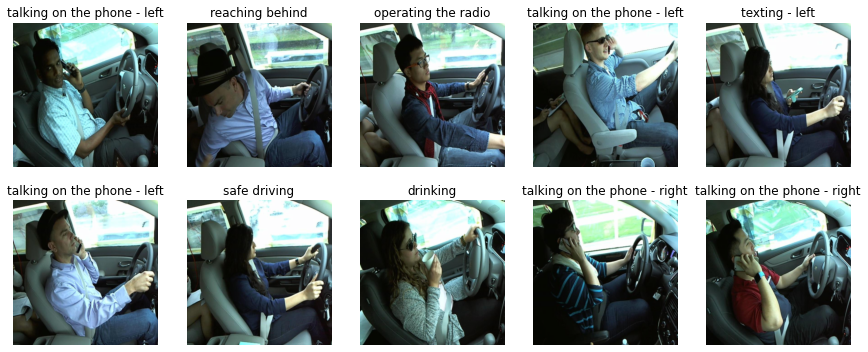

In [ ]:
from src import plot_utils

importlib.reload(plot_utils)
plot_utils.plot_classes(dset_loaders['train'])

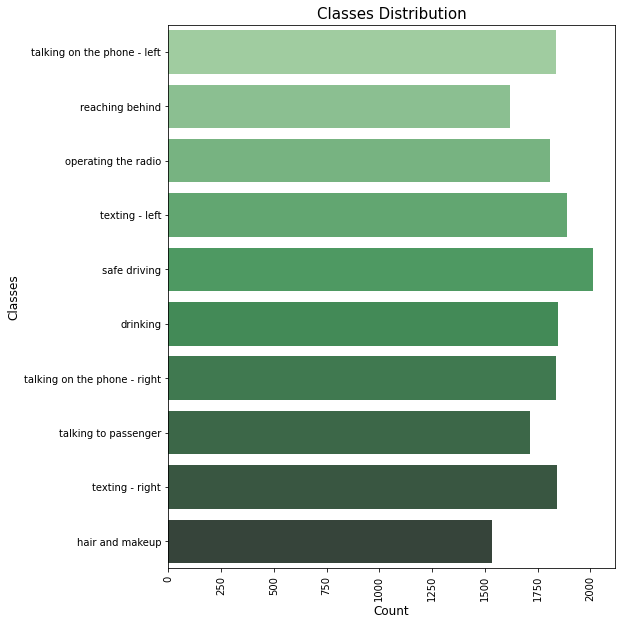

In [ ]:
classDistribution(dsets['train'])

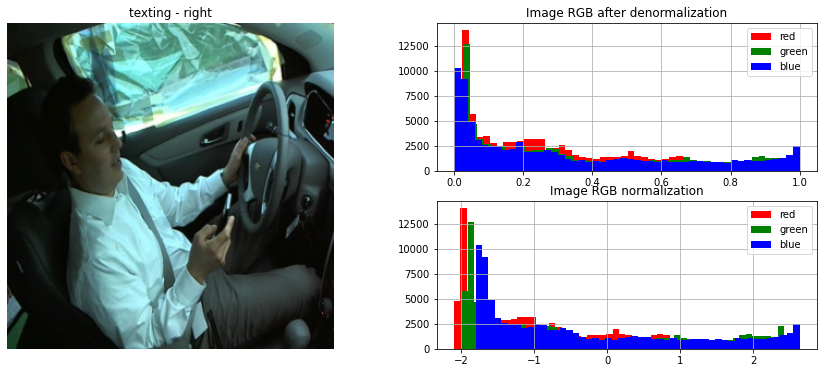

In [ ]:
from src import plot_utils

importlib.reload(plot_utils)
plot_utils.statistical_analysis_image(dset_loaders['train'])

In [ ]:
use_resnet = False
use_inception = True
use_denseNet = False

if use_resnet:
    print('Using ResNet model')
    model_name = "ResNet"
    model = MyResNet()
elif use_inception:
    print('Using Inception model')
    model_name = "Inception"
    model = MyInception()
elif use_denseNet:
    print('Using DenseNet model')
    model_name = "DenseNet"    
    model = MyDenseNet()

Using Inception model


In [ ]:
trainer.load_state(path2saveModel)
model.mrnd = trainer.model

In [ ]:
if use_gpu:
    if use_DataParalel:
        print("Using all GPU's ")
        model.mrnc = torch.nn.DataParallel(model.mrnc) #device_ids=[1,3]
        model.mrnc = model.mrnc.cuda()
        model.mrnd = torch.nn.DataParallel(model.mrnd) #device_ids=[1,3]
        model.mrnd = model.mrnd.cuda()
    else:
        print('Using GPU')# {}'.format(device_id))
        model.cuda()
else:
    print("Using CPU's")

Using all GPU's 


In [ ]:
from src import plot_utils

importlib.reload(plot_utils)
plot_utils.plot_layers_weight(dsets,img_width=img_width, img_height=img_height,conv_model = model.mrnc,use_gpu=use_gpu)

In [ ]:
path2results = "./results/"
load_results= load_prediction(path2results,model_name)


Loaded features with shapes: 


train:
pred torch.Size([17940, 10]), true torch.Size([17940])

valid:
pred torch.Size([4484, 10]), true torch.Size([4484])

test:
pred torch.Size([79726, 10]), true torch.Size([79726])


In [ ]:
pred = np.argmax(load_results['valid'][0], 1).numpy()
target = load_results['valid'][1].numpy()
sum([1 if i==j else 0 for (i,j) in zip(pred, target)])/len(target)

0.10347903657448707

In [ ]:
probas_matrix = torch.nn.functional.softmax(load_results['valid'][0])
probas, _ = torch.max(probas_matrix, 1)
probas = probas.data.numpy()
result_valid = {'probas': probas, 'pred': np.argmax(load_results['valid'][0].numpy(), 1), 'true': load_results['valid'][1].numpy()}
i_egal = np.where(result_valid['true'] == result_valid['pred'])[0]
i_not_egal = np.where(result_valid['true'] != result_valid['pred'])[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [ ]:
path2saveFigures = './figures/'

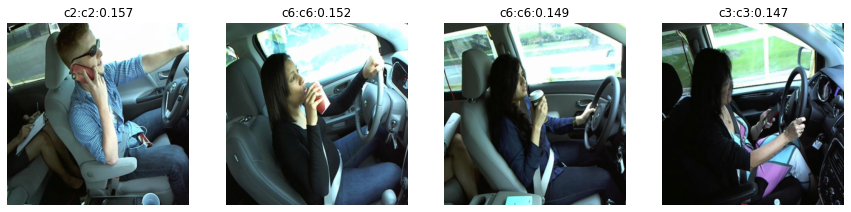

In [ ]:
top_predictions = np.argsort(result_valid['probas'][i_egal])[::-1]
y_top = i_egal[top_predictions]

visualize_predictions(dsets['valid'], y_top,  result_valid, path2saveFigures + 'right_higher')

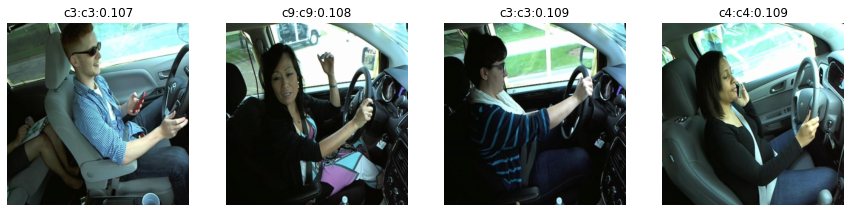

In [ ]:
top_predictions = np.argsort(result_valid['probas'][i_egal])
y_bot = i_egal[top_predictions]

visualize_predictions(dsets['valid'],  y_bot, result_valid, path2saveFigures + 'right_lower')

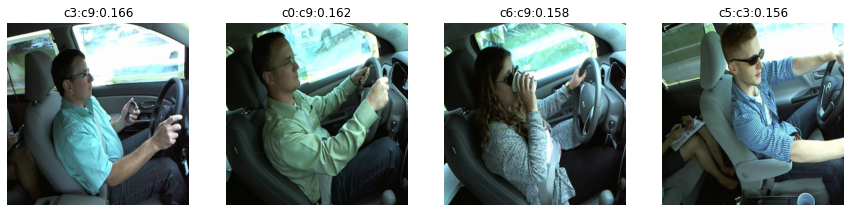

In [ ]:
top_predictions = np.argsort(result_valid['probas'][i_not_egal])[::-1]
y_top_not = i_not_egal[top_predictions]

visualize_predictions(dsets['valid'],  y_top_not, result_valid, path2saveFigures + 'wrong_higher')

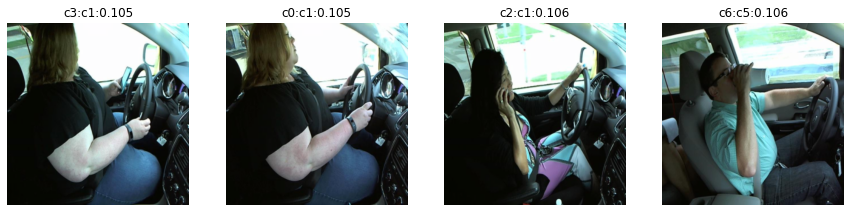

In [ ]:
top_predictions = np.argsort(result_valid['probas'][i_not_egal])
y_bot_not = i_not_egal[top_predictions]

visualize_predictions(dsets['valid'],  y_bot_not, result_valid, path2saveFigures + 'wrong_lower')

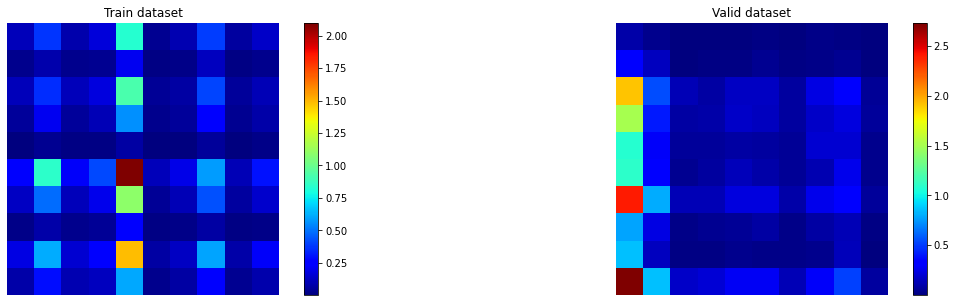

In [ ]:
results_train = {'pred': np.argmax(load_results['train'][0].numpy(), 1), 'true': load_results['train'][1].numpy()}
results_valid = {'pred': np.argmax(load_results['valid'][0].numpy(), 1), 'true': load_results['valid'][1].numpy()}
plot_cm_train_valid(results_train, results_valid, path2saveFigures + 'cm')

In [ ]:
!touch metrics/metrics_Inception.csv

In [1]:
# path2metrics = './metrics/metrics_'+ model_name+'.csv'
# plot_metrics(path2metrics, './figures/results_metrics_'+model_name+'.png')